# Image Captioning

This notebook is based on the programming assignment "CVND Image-Captioning-Project" of the Udacity Computer Vision Nanodegree. It was implemented in PyTorch and I reimplemented it using TensorFlow 2.2. The figures with the network architecture are taken from that assignment. 

We will build and train a model to automatically generate captions from images. The model consists of a pre-trained CNN encoder and an RNN decoder.

The dataset of image-caption pairs we use, is the Miscosoft Common Objects in Context [MS COCO dataset](http://cocodataset.org#home)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time
import pickle
import math

print(tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(physical_devices[0], 'GPU')

2.2.0


[nltk_data] Downloading package punkt to /home/vgkortsas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
batch_size = 64          # batch size
embed_size = 256           # dimensionality of image and word embeddings
hidden_size = 512          # number of features in hidden state of the RNN decoder
num_epochs = 10             # number of training epochs
save_every = 1             # determines frequency of saving model weights
print_every = 400          # determines window for printing average loss

#### The next cell is copied from the Udacity assignment. It loads and pre-process data from the [COCO dataset](http://cocodataset.org#home) in order to generate image-caption pairs to train the model. Pytorch is only used to load and process the data. It is not used in the training and testing of the model. 

In [3]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.utils.data as data
from torchvision import transforms

import sys
sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader

vocab_threshold = 4        # minimum word count threshold
vocab_from_file = False   # if True, load existing vocab file

# Transform to pre-process the training images
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Build data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=vocab_from_file)

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

loading annotations into memory...
Done (t=0.52s)
creating index...
index created!
[0/414113] Tokenizing captions...
[100000/414113] Tokenizing captions...
[200000/414113] Tokenizing captions...
[300000/414113] Tokenizing captions...
[400000/414113] Tokenizing captions...
loading annotations into memory...
Done (t=0.60s)
creating index...


  0%|          | 1006/414113 [00:00<00:41, 10055.43it/s]

index created!
Obtaining caption lengths...


100%|██████████| 414113/414113 [00:41<00:00, 9867.19it/s] 


## Model architecture

The model consists of a pre-trained CNN encoder (pre-trained ResNet-50 architecture with the final fully-connected layer removed and replaced with an embedding layer, which transforms the feature vector from the input image in order to have the same size as the word embeddings of the input captions in the decoder) which takes as input a pre-processed image and gives embedded image features as output and an RNN decoder consisting of LSTM units which take as input the encoder output and the words of the corresponding image caption and gives as output the predicted image caption.

<img src="images/encoder-decoder.png" style="width:400;height:400px;"> <br>

In [4]:
IMAGE_SIZE = 224
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)


class Encoder(tf.keras.layers.Layer): 
    def __init__(self, embed_size):
        super(Encoder, self).__init__()
        self.res_net = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
        self.res_net.trainable = False
        
        self.global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
        self.output_layer = tf.keras.layers.Dense(embed_size)
        
    def call(self, images):
        features_1 = self.res_net(images)
        features_2 = self.global_average_layer(features_1)
        encoder_output = self.output_layer(features_2)
        
        return encoder_output
    

class Decoder(tf.keras.layers.Layer): 
    def __init__(self, embed_size, hidden_size, vocab_size):
        super(Decoder, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_size)
        self.LSTM_cell = tf.keras.layers.LSTM(hidden_size, return_sequences=True, return_state=True)
        self.output_layer = tf.keras.layers.Dense(vocab_size, activation='softmax')
               
    def call(self, features, captions):
        captions_embedding = self.embedding(captions[:, :-1]) # so not including <end> in the input
        features = tf.expand_dims(features, axis=1) # shape: (None, 1, embed_size)
        lstm_input =  tf.keras.layers.concatenate([features, captions_embedding],axis=1) # shape: (None, caption.shape(1), embed_size)
        lstm_output, _, _ = self.LSTM_cell(lstm_input)
        decoder_output = self.output_layer(lstm_output)
        
        return decoder_output
    
    def sample(self, inputs, max_len=20):
        inputs = tf.expand_dims(inputs, axis=1) # shape: (1, 1, embed_size)
        assert tf.rank(inputs).numpy() in [2,3]
        
        if (tf.rank(inputs).numpy()==2):
            inputs = tf.expand_dims(inputs, axis=1)
            
        inference_output = []
        for i in range(max_len):
            if (i == 0):
                hidden, state_h , state_c = self.LSTM_cell(inputs)
            else:
                hidden, state_h , state_c = self.LSTM_cell(inputs, initial_state = [state_h , state_c])
            decoder_output = self.output_layer(hidden)
            word_id = tf.argmax(decoder_output, axis =2)
            inference_output.append(word_id.numpy().item())
            inputs = self.embedding(word_id)
            
        return inference_output

In [5]:
class image_captioning_model(tf.keras.Model): 
    def __init__(self, embed_size, hidden_size, vocab_size):
        super(image_captioning_model, self).__init__()
        self.encoder = Encoder(embed_size)
        self.decoder = Decoder(embed_size, hidden_size, vocab_size)
        
    def call(self, images, captions): 
        encoder_output_features = self.encoder(images)
        predictions = self.decoder(encoder_output_features, captions)
        
        return predictions
    
    def sample(self, image):
        encoder_output = self.encoder(image)
        inference_output = self.decoder.sample(encoder_output)
        
        return inference_output
    
image_captioning = image_captioning_model(embed_size = embed_size, hidden_size = hidden_size, vocab_size = vocab_size)

## Training

In [7]:
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate)
total_step = math.ceil(len(data_loader.dataset.caption_lengths) / data_loader.batch_sampler.batch_size)

history_loss_per_epoch = []
history_loss = []

start_time = time.time()
for epoch in range(1, num_epochs+1):
 
    loss_per_epoch = []

    for i_step in range(1, total_step+1):
        
        # Randomly sample a caption length, and sample indices with that length.
        indices = data_loader.dataset.get_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        data_loader.batch_sampler.sampler = new_sampler
        
        # Obtain the batch
        images, captions = next(iter(data_loader))
        
        images_tf = images.numpy()
        images_tf = tf.convert_to_tensor(images_tf)
        images_tf = tf.transpose(images_tf, perm=[0, 2, 3, 1])
        
        captions_tf = captions.numpy()
        captions_tf = tf.convert_to_tensor(captions_tf)
        
        with tf.GradientTape() as tape:
        
            decoder_predictions = image_captioning(images_tf, captions_tf)
            loss = tf.keras.losses.sparse_categorical_crossentropy(captions_tf, decoder_predictions)
         
        grads = tape.gradient(loss, image_captioning.trainable_variables)
        optimizer.apply_gradients(zip(grads, image_captioning.trainable_variables))        
        
        loss_per_epoch.append(loss.numpy().mean())
        history_loss.append(loss.numpy().mean())
        
        if i_step % print_every == 0:
            elapsed_time = time.time() - start_time           
            print("Epoch {}/{} Batch {}/{} Train loss {:.7f} Time {:.2f} min".format(
                   epoch, num_epochs, i_step, total_step, loss.numpy().mean(), elapsed_time/60))
                                    
    history_loss_per_epoch.append(np.mean(np.array(loss_per_epoch)))
    
    print("Epoch {} Train loss {:.4f} ".format(
                 epoch, np.mean(np.array(loss_per_epoch))))
    
    # Save the weights
    if epoch % save_every == 0:
        image_captioning.save_weights('./checkpoints/my_checkpoint_epoch_'+str(epoch))
    
output = open('history_loss.pkl', 'wb')
pickle.dump(history_loss, output)
output.close()

output = open('history_loss_per_epoch.pkl', 'wb')
pickle.dump(history_loss_per_epoch, output)
output.close()

Epoch 1/10 Batch 400/6471 Train loss 3.3605602 Time 6.08 min
Epoch 1/10 Batch 800/6471 Train loss 3.3069336 Time 12.17 min
Epoch 1/10 Batch 1200/6471 Train loss 3.0951335 Time 18.27 min
Epoch 1/10 Batch 1600/6471 Train loss 2.7832811 Time 24.35 min
Epoch 1/10 Batch 2000/6471 Train loss 2.8653760 Time 30.44 min
Epoch 1/10 Batch 2400/6471 Train loss 2.9123847 Time 36.53 min
Epoch 1/10 Batch 2800/6471 Train loss 2.9230468 Time 42.61 min
Epoch 1/10 Batch 3200/6471 Train loss 2.6287501 Time 48.69 min
Epoch 1/10 Batch 3600/6471 Train loss 2.8381572 Time 54.79 min
Epoch 1/10 Batch 4000/6471 Train loss 2.4326792 Time 60.87 min
Epoch 1/10 Batch 4400/6471 Train loss 2.3807843 Time 66.96 min
Epoch 1/10 Batch 4800/6471 Train loss 2.3902543 Time 73.07 min
Epoch 1/10 Batch 5200/6471 Train loss 2.2829368 Time 79.17 min
Epoch 1/10 Batch 5600/6471 Train loss 2.4692607 Time 85.26 min
Epoch 1/10 Batch 6000/6471 Train loss 2.2746370 Time 91.34 min
Epoch 1/10 Batch 6400/6471 Train loss 2.2041240 Time 97.43

Epoch 8/10 Batch 6000/6471 Train loss 2.0059528 Time 779.28 min
Epoch 8/10 Batch 6400/6471 Train loss 1.7710398 Time 785.36 min
Epoch 8 Train loss 1.9986 
Epoch 9/10 Batch 400/6471 Train loss 2.0267642 Time 792.51 min
Epoch 9/10 Batch 800/6471 Train loss 2.3391490 Time 798.60 min
Epoch 9/10 Batch 1200/6471 Train loss 1.9245076 Time 804.69 min
Epoch 9/10 Batch 1600/6471 Train loss 1.9215513 Time 810.77 min
Epoch 9/10 Batch 2000/6471 Train loss 2.0936532 Time 816.83 min
Epoch 9/10 Batch 2400/6471 Train loss 1.8635427 Time 822.92 min
Epoch 9/10 Batch 2800/6471 Train loss 2.0849214 Time 828.98 min
Epoch 9/10 Batch 3200/6471 Train loss 1.9751285 Time 835.04 min
Epoch 9/10 Batch 3600/6471 Train loss 2.0482633 Time 841.12 min
Epoch 9/10 Batch 4000/6471 Train loss 1.9902283 Time 847.21 min
Epoch 9/10 Batch 4400/6471 Train loss 1.8469633 Time 853.31 min
Epoch 9/10 Batch 4800/6471 Train loss 2.1029196 Time 859.40 min
Epoch 9/10 Batch 5200/6471 Train loss 1.8099406 Time 865.48 min
Epoch 9/10 Batc

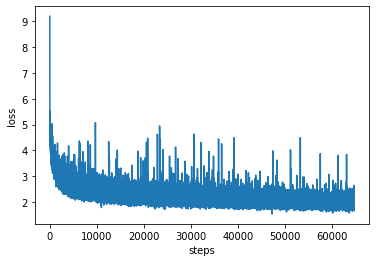

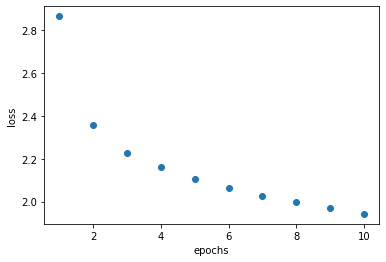

In [8]:
fig = plt.figure()
plt.plot(range(1, num_epochs*total_step+1), history_loss)
plt.xlabel('steps')
plt.ylabel('loss')
plt.show()
fig.savefig('loss per each step.png')

fig = plt.figure()
plt.scatter(range(1, num_epochs+1), history_loss_per_epoch)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()
fig.savefig('loss per each epoch.png')

## Test

#### The next cell is copied from the Udacity assignment and is used to pre-process the test images. 

In [9]:
transform_test = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Create the data loader.
data_loader = get_loader(transform=transform_test,    
                         mode='test')

Vocabulary successfully loaded from vocab.pkl file!


In [10]:
image_captioning.load_weights('./checkpoints/my_checkpoint_epoch_10')

def clean_sentence(output):
    word = [data_loader.dataset.vocab.idx2word[x] for x in output]
    id_start = [i for i, w in enumerate(word) if w == '<start>']
    id_end = [i for i, w in enumerate(word) if w == '<end>']
    sentence = ' '.join(word[id_start[-1]+1:id_end[0]])
    return sentence

def get_prediction():
    original_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(original_image))
    plt.title('Sample Image')
    plt.show()
    
    image_tf = image.numpy()
    image_tf = tf.convert_to_tensor(image_tf)
    image_tf = tf.transpose(image_tf, perm=[0, 2, 3, 1])

    output = image_captioning.sample(image_tf)   
    sentence = clean_sentence(output)
    print(sentence)

## The model perfomed well in the following cases:

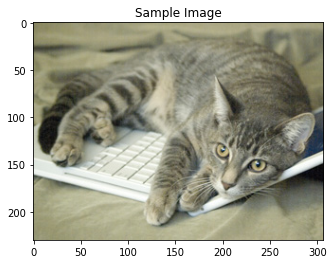

a cat is laying on top of a laptop .


In [19]:
get_prediction()

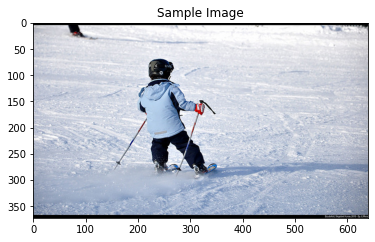

a man riding skis down a snow covered slope .


In [165]:
get_prediction()

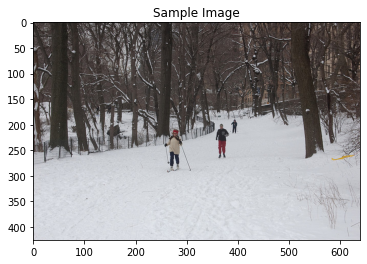

a group of people skiing down a snow covered slope .


In [30]:
get_prediction()

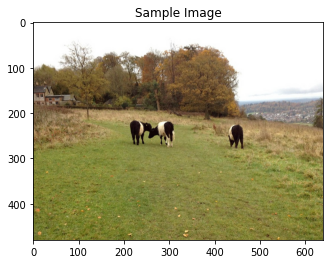

a group of cows standing on a lush green field .


In [116]:
get_prediction()

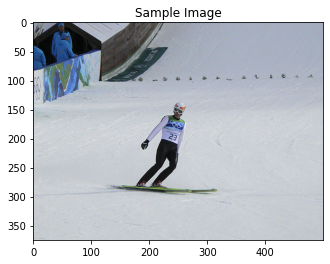

a man is skiing down a snow covered hill .


In [48]:
get_prediction()

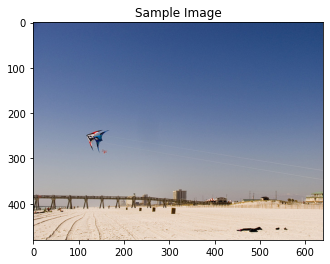

a group of people flying kites in a field .


In [70]:
get_prediction()

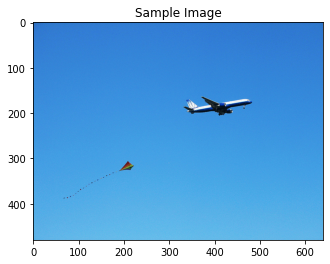

a large jetliner flying through a blue cloudy sky .


In [169]:
get_prediction()

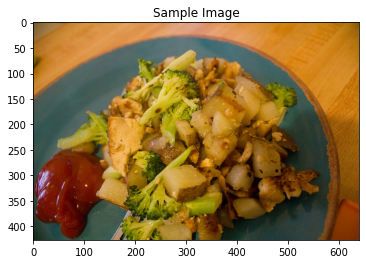

a plate of food with broccoli and potatoes .


In [103]:
get_prediction()

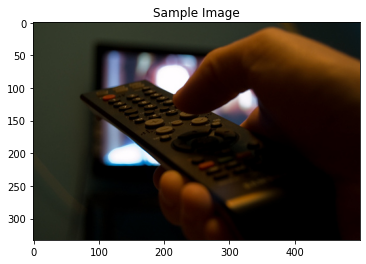

a man is holding a remote control in his hand .


In [49]:
get_prediction()

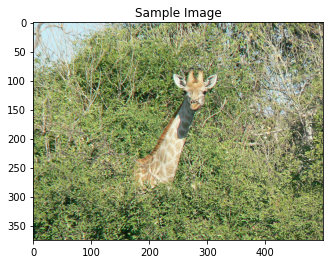

a giraffe standing in a field next to a tree .


In [146]:
get_prediction()

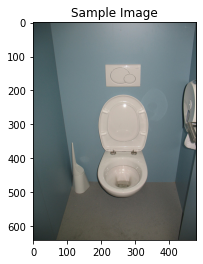

a toilet with a lid and toilet paper roll .


In [87]:
get_prediction()

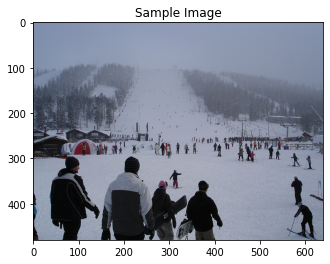

a group of people standing on top of a snow covered slope .


In [128]:
get_prediction()

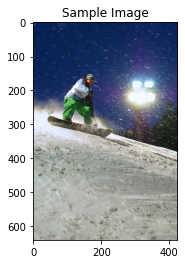

a person riding a snowboard down a snow covered slope .


In [84]:
get_prediction()

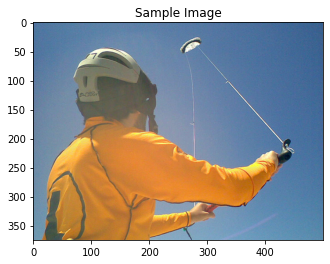

a man is holding a kite in a field


In [107]:
get_prediction()

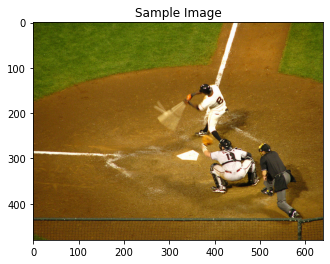

a baseball player is swinging a bat at a ball


In [138]:
get_prediction()

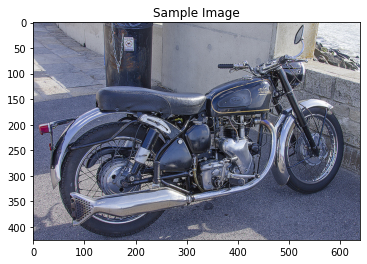

a motorcycle parked on the side of a road .


In [52]:
get_prediction()

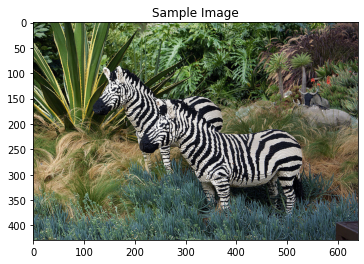

a group of zebras are standing in a field .


In [51]:
get_prediction()

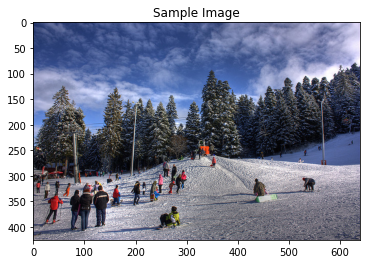

a group of people standing on top of a snow covered slope .


In [73]:
get_prediction()

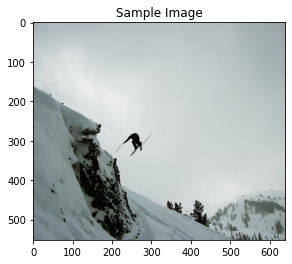

a person on a snowboard in the snow .


In [106]:
get_prediction()

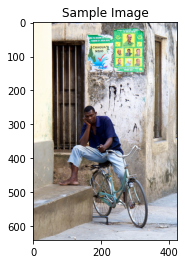

a man is standing in front of a door


In [78]:
get_prediction()

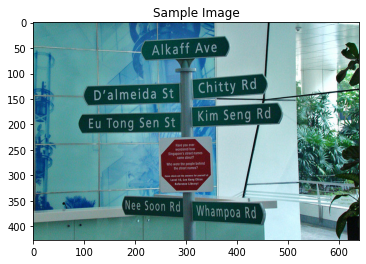

a sign that reads `` <unk> street <unk> '' on a pole .


In [82]:
get_prediction()

## The model could have performed better ...

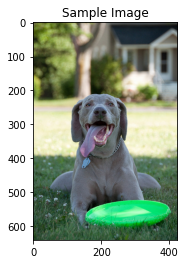

a dog with a frisbee in its mouth running in a field .


In [167]:
get_prediction()

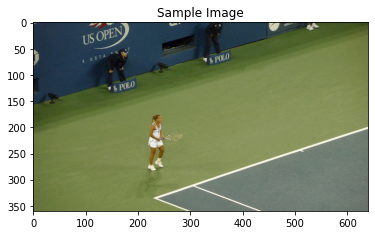

a man playing tennis on a tennis court .


In [80]:
get_prediction()

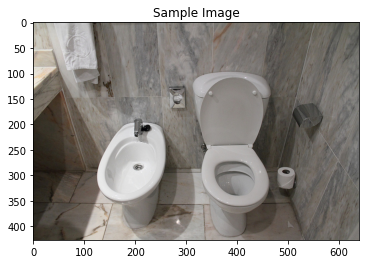

a toilet with a wooden seat and a white toilet seat .


In [40]:
get_prediction()

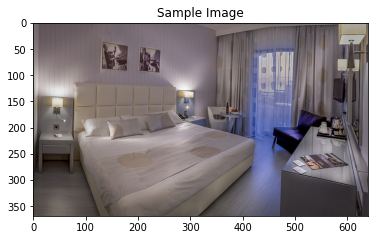

a bed with a white comforter and a black blanket .


In [59]:
get_prediction()

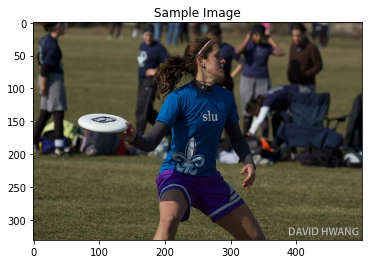

a woman is holding a stuffed bear in a garden .


In [77]:
get_prediction()

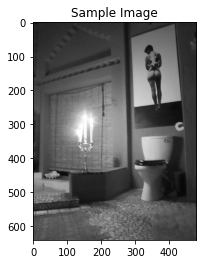

a bathroom with a toilet and a sink


In [79]:
get_prediction()